# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+. Описание проекта.

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:  
- лог сервера с данными об их посещениях,  
- выгрузка их покупок за этот период,  
- рекламные расходы.

**Предстоит изучить:**  
- откуда приходят пользователи и какими устройствами они пользуются;    
- сколько стоит привлечение пользователей из различных рекламных каналов;  
- сколько денег приносит каждый клиент;  
- когда расходы на привлечение клиента окупаются;  
- какие факторы мешают привлечению клиентов.

**Описание данных:**  
Имеются три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

**Структура visits_info_short.csv:**  
User Id — уникальный идентификатор пользователя,  
Region — страна пользователя,  
Device — тип устройства пользователя,  
Channel — идентификатор источника перехода,  
Session Start — дата и время начала сессии,  
Session End — дата и время окончания сессии.

**Структура orders_info_short.csv:**  
User Id — уникальный идентификатор пользователя,  
Event Dt — дата и время покупки,  
Revenue — сумма заказа.  

**Структура costs_info_short.csv:**  
dt — дата проведения рекламной кампании,  
Channel — идентификатор рекламного источника,  
costs — расходы на эту кампанию.


## Подготовка данных к анализу

Изучим данные и выполним их предобработку.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

### Таблица с посещениями

In [3]:
visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# Приведём названия столбцов к змеиному регистру и изменим тип данных в столбцах с датой
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [6]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [7]:
# Проверим на наличие дубликатов
visits.duplicated().sum()

0

### Таблица с заказами

In [8]:
orders.head(10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [11]:
# Проверим на наличие дубликатов
orders.duplicated().sum()

0

### Таблица с затратами на рекламу

In [12]:
costs.head(10)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [14]:
costs.columns = costs.columns.str.lower()

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [15]:
# Проверим на наличие дубликатов
costs.duplicated().sum()

0

### Вывод по данным.

Были изменены названия столбцов. Данные в колонках с датами приведены в соответствующий формат. Дубликаты и пропуски отсутствуют.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функции для расчёта метрик

#### Функция для создания профилей пользователей

In [16]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

  

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания пользователей

In [17]:
# Создадим функицю для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 
    

#### Функция для расчёта конверсии

In [18]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта LTV и ROI

In [19]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для визуализации метрик


#### Функция для сглаживания датафрейма

In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция для визуализации удержания

In [21]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для визуализации конверсии

In [22]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей и определим минимальную и максимальную даты привлечения.

In [24]:
# Получим профили пользователей с помощью функции get_profiles
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [25]:
# Определим минамильную и максимальную даты
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()

print('Минимальная дата привлечения: {}\n'
     'Максимальная дата привлечения: {}'.format(min_analysis_date, max_analysis_date))

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


### Пользователи по странам

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [26]:
profiles_by_region = (profiles
                      .pivot_table(index='region', values='payer', aggfunc=['count', 'sum', 'mean'])
                      .rename(columns={'count' : 'Пользователи', 'sum' : 'Платящие', 'mean' : 'Доля платящих'})
                      .droplevel(1, axis=1)
                      .sort_values(by='Доля платящих', ascending=False)
                      .style.format({'Доля платящих':'{:.2%}'})
                     )
profiles_by_region

,Пользователи,Платящие,Доля платящих
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Из таблицы видно, что доля платящих пользователей из США почти на 3% превышает доли платящих из других регионов.

### Пользователи по устройствам

Посмотрим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [27]:
profiles_by_device = (profiles
                      .pivot_table(index='device', values='payer', aggfunc=['count', 'sum', 'mean'])
                      .rename(columns={'count' : 'Пользователи', 'sum' : 'Платящие', 'mean' : 'Доля платящих'})
                      .droplevel(1, axis=1)
                      .sort_values(by='Доля платящих', ascending=False)
                      .style.format({'Доля платящих':'{:.2%}'})
                     )
profiles_by_device

,Пользователи,Платящие,Доля платящих
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


У Mac самая высокая доля платящих пользователей. Чуть ниже доля у iPhone, тем не менее эта катеогрия приносит больше всего юзеров, в том числе и платящих. Почти на процент отстают пользователи PC.

###  Пользователи по каналам привлечения

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [28]:
profiles_by_channel = (profiles
                      .pivot_table(index='channel', values='payer', aggfunc=['count', 'sum', 'mean'])
                      .rename(columns={'count' : 'Пользователи', 'sum' : 'Платящие', 'mean' : 'Доля платящих'})
                      .droplevel(1, axis=1)
                      .sort_values(by='Доля платящих', ascending=False)
                      .style.format({'Доля платящих':'{:.2%}'})
                     )
profiles_by_channel

,Пользователи,Платящие,Доля платящих
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


Наибольшая доля платящих прибыла из следующих источников: FaceBoom, AdNonSense, lambdaMediaAds. При этом самые популярные среди всех - FaceBoom и TipTop. Самая маленькая доля платящих в источнике organic, но они всё равно молодцы, потому что на их привлечение не было потрачено денег.

## Маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [29]:
cac_sum = costs['costs'].sum().round(2)
cac_sum

105497.3

На рекламную кампанию было потрачено 105 497.3$

Выясним, как траты распределены по рекламным источникам.


In [30]:
cac_by_channel = (costs
                  .pivot_table(index='channel', values='costs', aggfunc='sum')
                  .sort_values(by='costs', ascending=False)
                  .rename(columns={'costs' : 'Затрачено $'})
                 )
cac_by_channel['Доля'] = (cac_by_channel['Затрачено $']/cac_by_channel['Затрачено $'].sum())
cac_by_channel = cac_by_channel.style.format({'Доля':'{:.2%}'})
cac_by_channel

,Затрачено $,Доля
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


Основную долю расходов берут (более 80%) на себя TipTop и FaceBoom.

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.


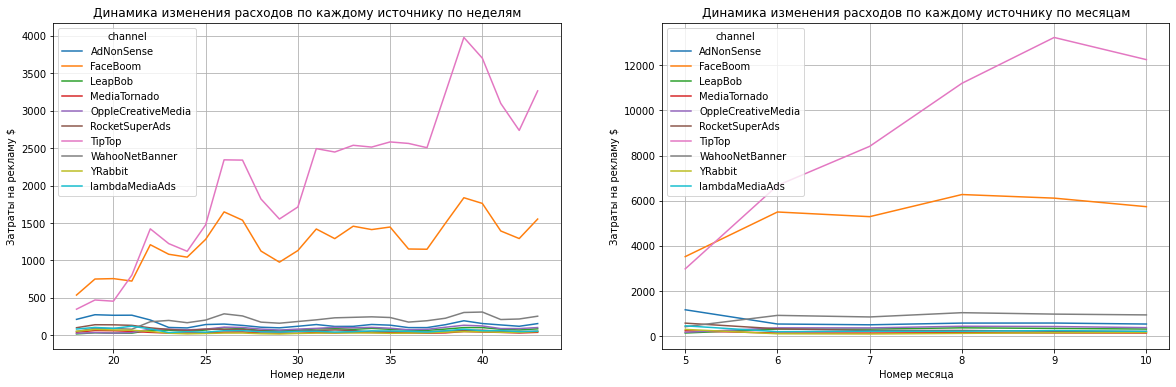

In [31]:
costs['date_month'] = pd.DatetimeIndex(costs['dt']).month
costs['date_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

plt.figure(figsize=(20, 6))
cac_in_week = (costs
               .pivot_table(index='date_week', columns='channel', values='costs', aggfunc='sum')
              )
cac_in_week.plot(grid=True, ax=plt.subplot(1, 2, 1))
plt.title('Динамика изменения расходов по каждому источнику по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Затраты на рекламу $')

cac_in_month = (costs
               .pivot_table(index='date_month', columns='channel', values='costs', aggfunc='sum')
              )
cac_in_month.plot(grid=True, ax=plt.subplot(1, 2, 2))
plt.title('Динамика изменения расходов по каждому источнику по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Затраты на рекламу $')
plt.show()

Заметно, что большая часть денег уходила на рекламу в TipTop и FaceBoom.

Определим также, сколько в среднем стоило привлечение одного пользователя из каждого источника.

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


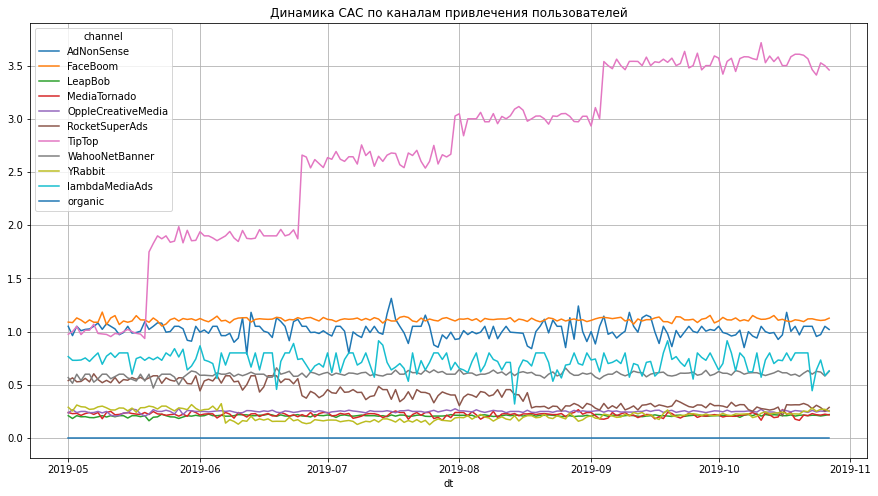

In [32]:
avg_cac = (profiles
           .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
           .sort_values(by='acquisition_cost', ascending=False)
          )
display(avg_cac)

(profiles
 .pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')
 .plot(grid=True, figsize=(15,8))
)
plt.title('Динамика САС по каналам привлечения пользователей')
plt.show()

In [33]:
print('Cредний CAC на одного пользователя для всего проекта:', 
      round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2),'$')

Cредний CAC на одного пользователя для всего проекта: 1.13 $


Самые дорогие пользователи приходят из TipTop, каждый в среднем обошёлся почти в 3 доллара (в 2 раза превышающие ср значение). Также почти в доллар за человека обошлись пользователи из FaceBoom и AdNonSense.

Таким образом, общая сумма затрат на маркетинг за период рекламной кампании составила 105 497 долл, средняя стоимость привлечения на пользователя по всему проекту - 1.13 долл. Более 80% расходов направлено на каналы привлечения TipTop и FaceBoom. В динамике также можно увидеть рост затрат на эти каналы.

## Оценка окупаемости рекламы

### Анализ общей окупаемости рекламы

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI. Дата анализа 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

In [34]:
# Установим момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

# Также исключим пользователей с каналом привлечения organic
profiles = profiles.query('channel != "organic"')

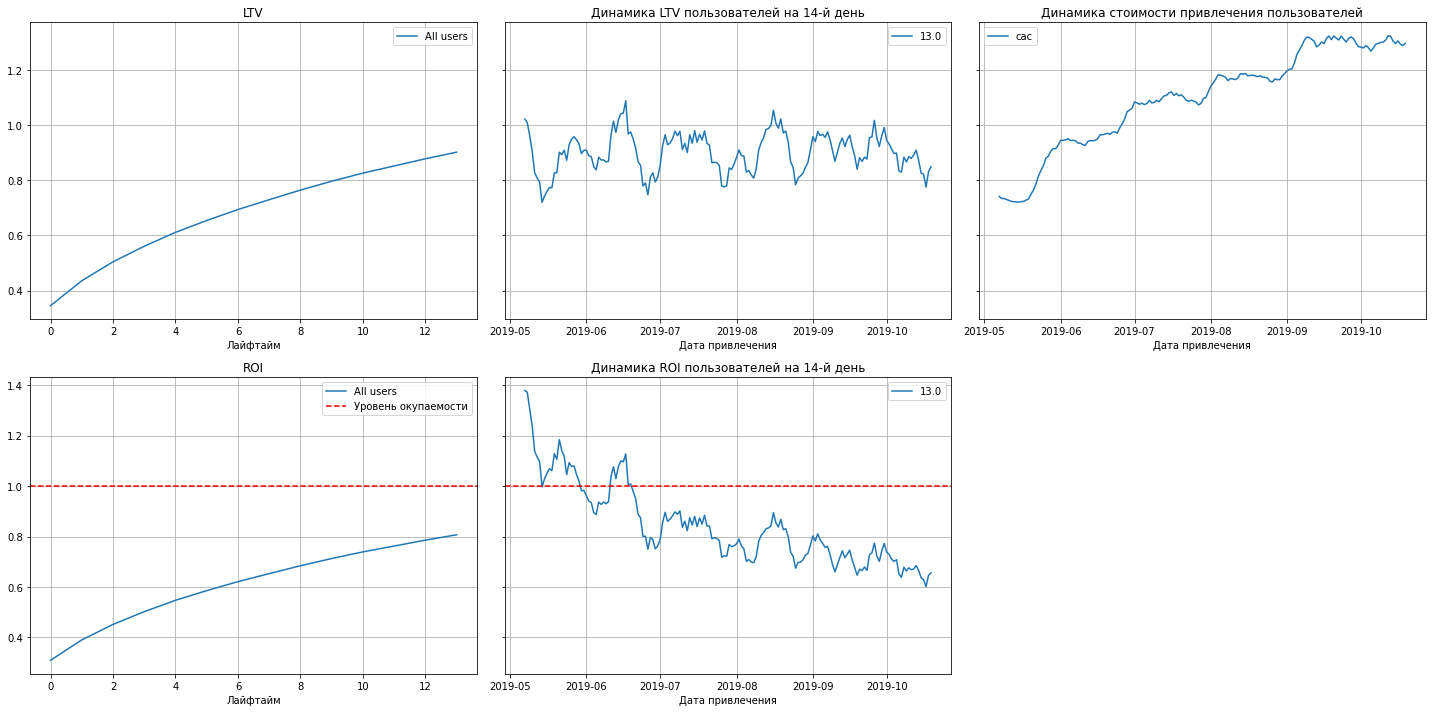

In [35]:
# Посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков видно, что LTV идёт вверх, но из-за увеличивающихся затртат на рекламу, ROI меньеше 1 и реклама не окупается.

### Анализ конверсии и удержания

Проверим конверсию пользователей и удержание, а также динамику их изменений. 

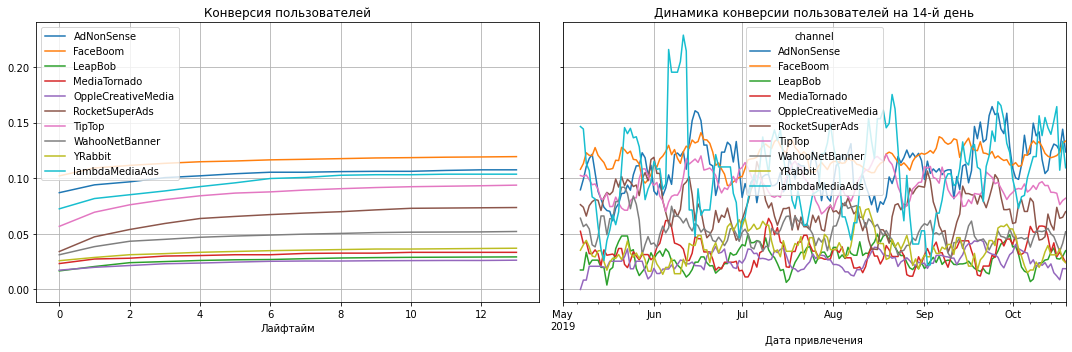

In [36]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

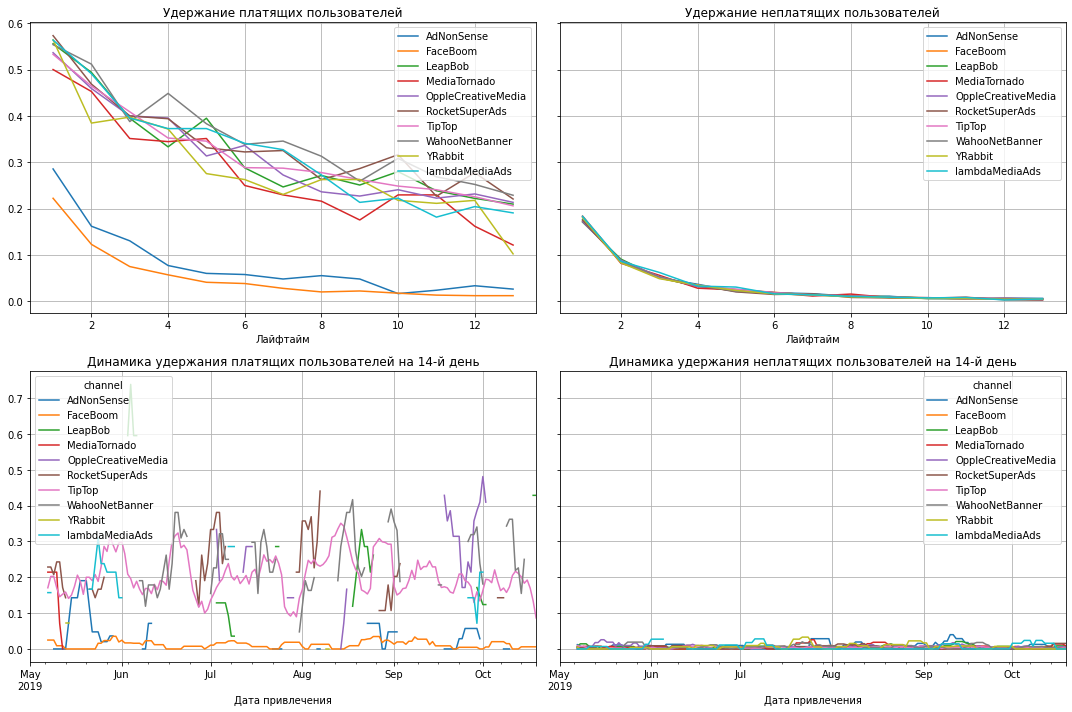

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Судя по графикам, с конверисей всё хорошо, но вот удержание по каналам с самой высокой стоимостью привлечения за человека, FaceBoom и AdNonSense, страдает.

### Окупаемость рекламы с разбивкой по устройствам

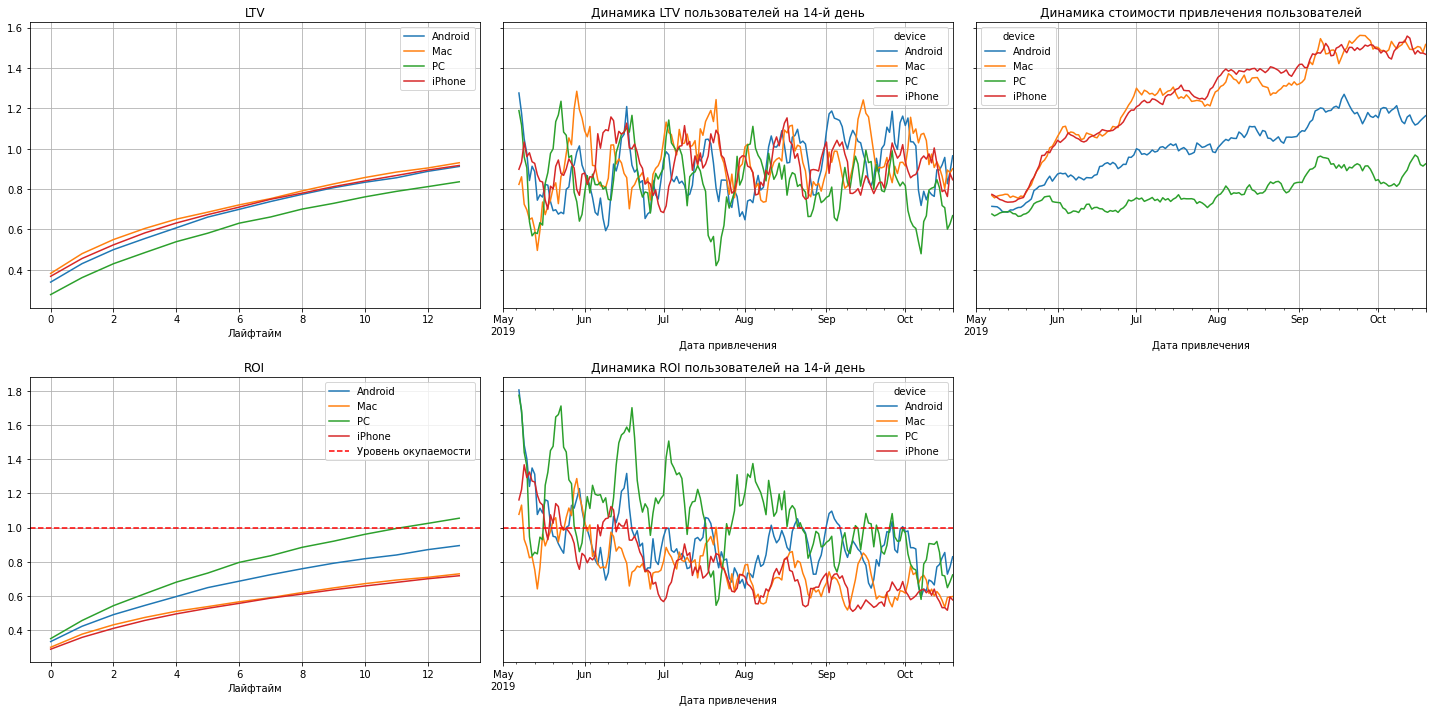

In [38]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно наблюдать, что LTV у всех в норме, немного отстаёт PC. Но и затраты на привлечение пользователей PC самые низкие, поэтому только у PC ROI выходит в плюс. Самые дорогие и нерентабельные пользователи устройств iPhone и Mac. Посмотрим на показатели конверсии и удержания по устройствам.


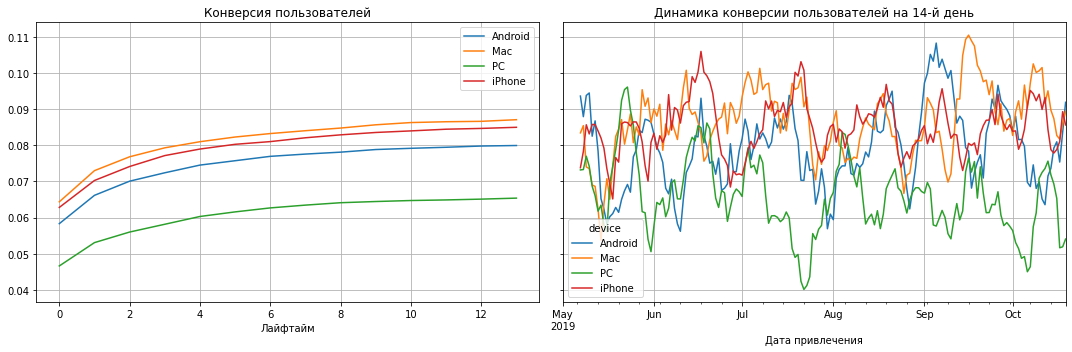

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

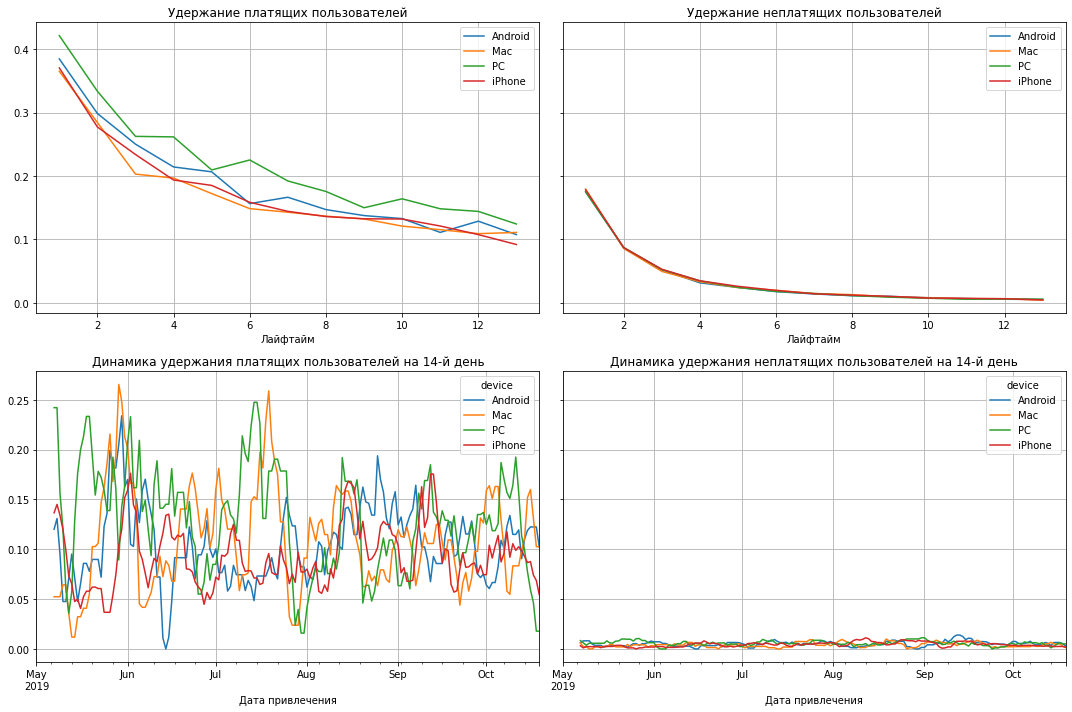

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание у всех примерно одинаковое, нужно скорее всего снижать затраты на привлечение

### Окупаемость с разбивкой по странам

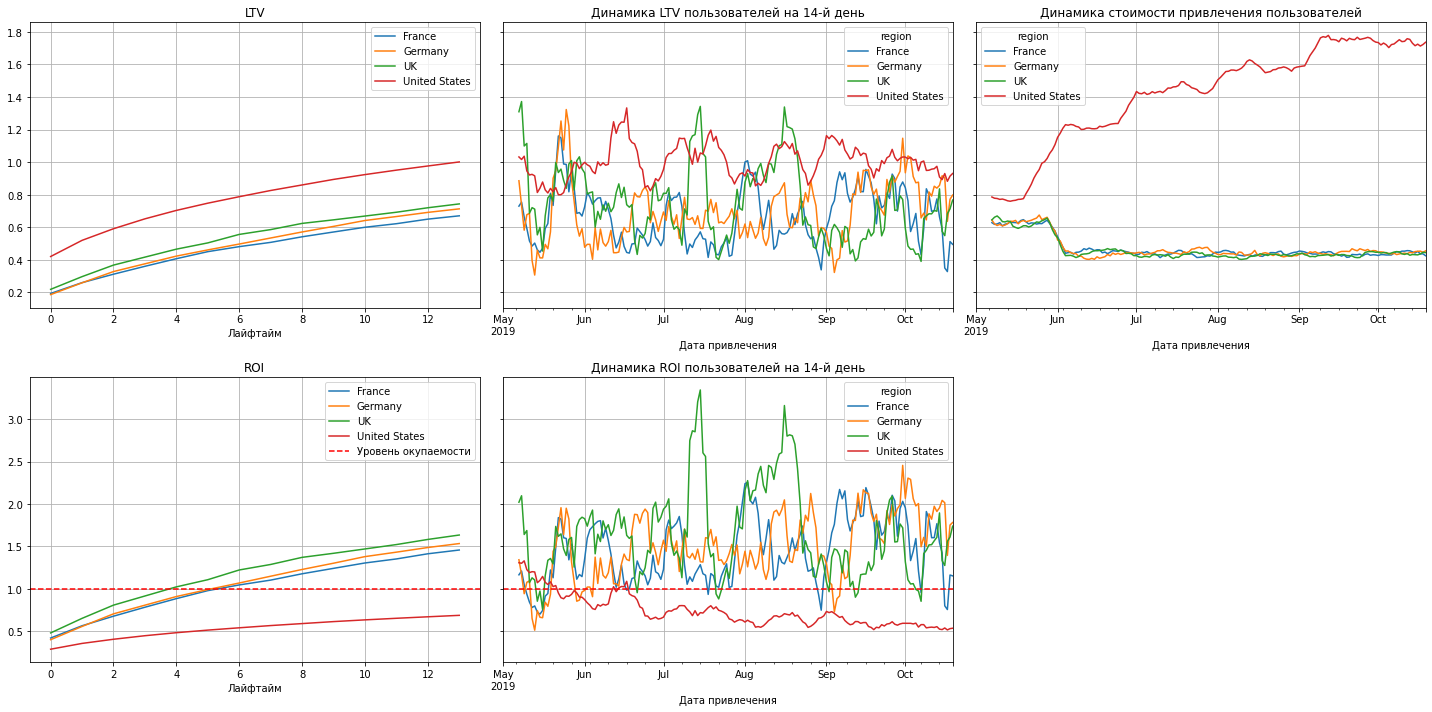

In [41]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выделяются пользователи из США. С одной стороны они приносят больше всего денег, с другой - требуют больше всего затрат на привлечение и потому ROI ниже единицы. Рассмотрим их конверисю и удержание.

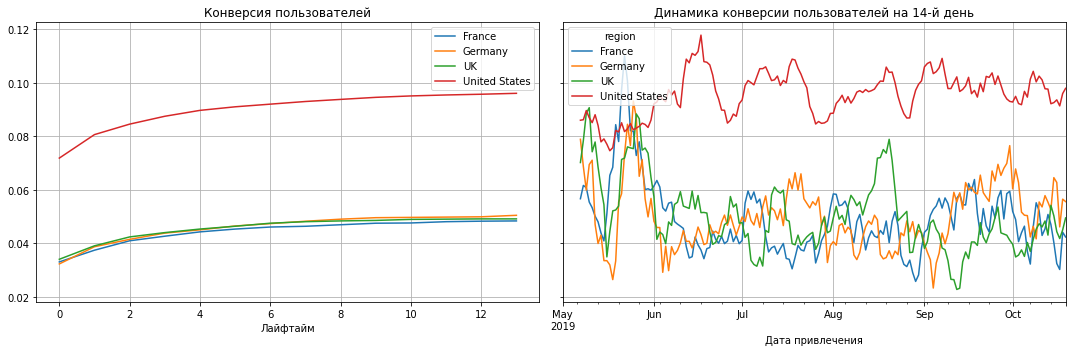

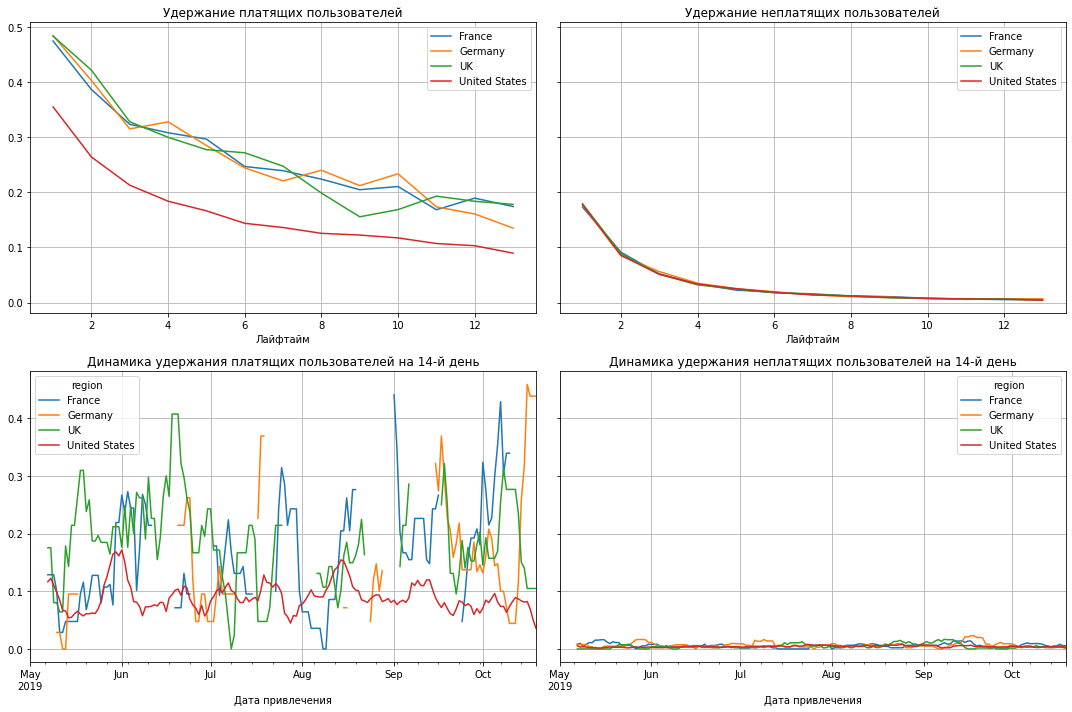

In [42]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия пользователей из США лучше, чем у остальных регионов, а вот удержание сильно отстаёт.

### Окупаемость с разбивкой по каналам привлечения

Изучим каналы привлечения по регионам. Разделим пользователей США и Европы.

In [43]:
# Определим отношение пользователей из США к общему числу пользователй
profiles_us = profiles.query('region == "United States"')
print('Доля пользователей из США:',round((len(profiles_us)/len(profiles)), 2))

Доля пользователей из США: 0.66


Мы видим, что основная масса пользователей из США.

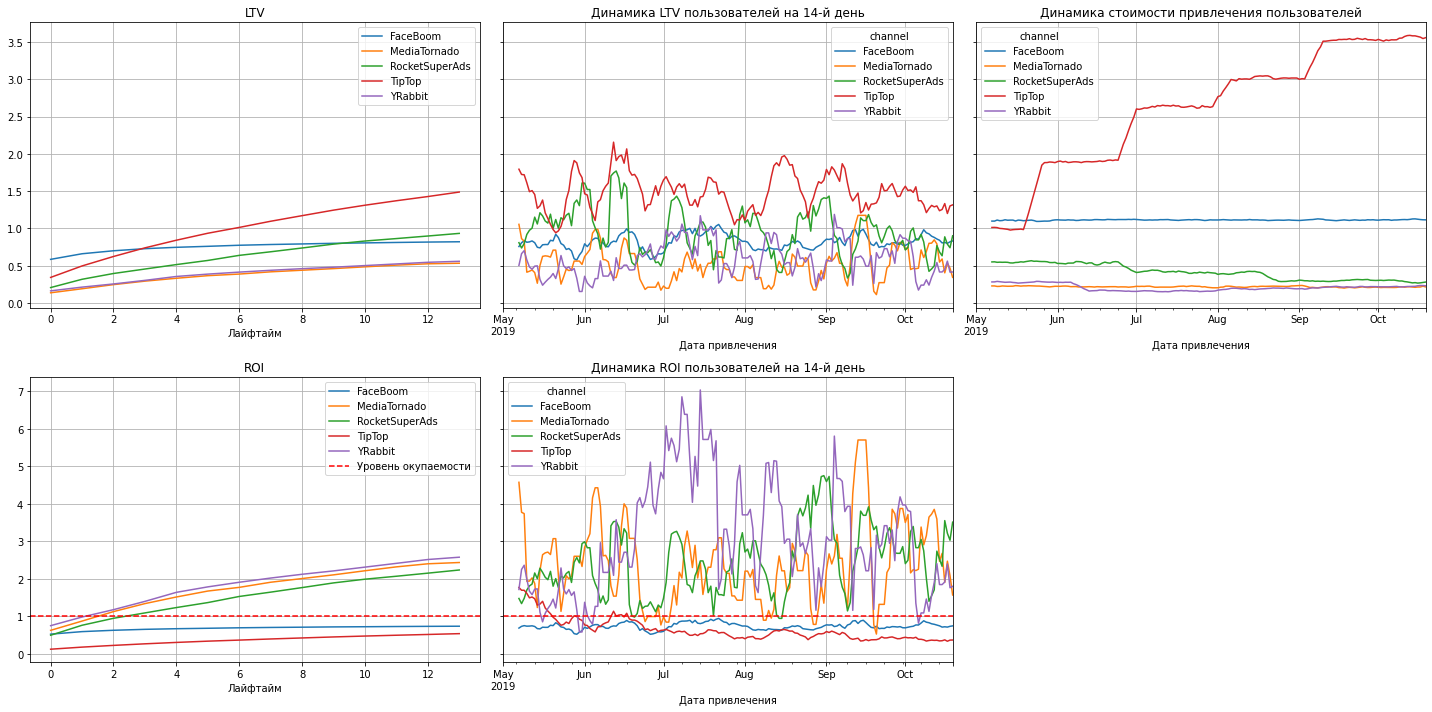

In [44]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Пользователи США, которые пришли из TipTop и FaceBoom,  приносят убытки. TipTop показывает самый высокий и стабильный в динамике LTV, но САС при этом постоянно растет. Таким образом, ROI не достигает даже 70%. FaceBoom также стабильно убыточен, рост его LTV происходит в первые два дня, а САС находится на постоянном уровне, поэтому ROI находится в районе 80-90%.

Далее рассмотрим пользователей из Европы

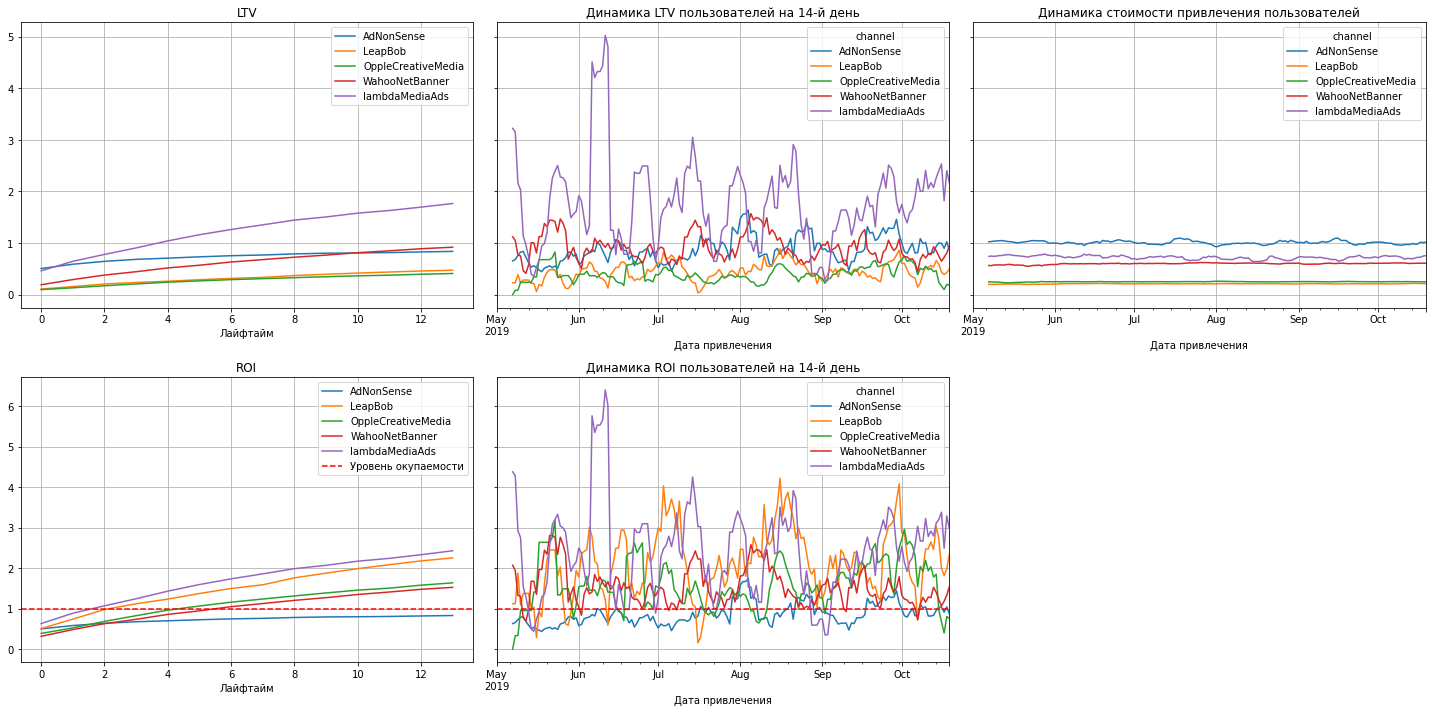

In [45]:
profiles_eu = profiles.query('region != "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions=dimensions
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

В Европе один проблемный канал - AdNonSense, стабильный CAC около 1 долл, LTV чуть ниже этого показателя, оттого и получаем ROI около 90%.

Проанализировав окупаемость рекламы в целом, мы можем видеть, что расходы на рекламу перекрывают доходы. Показатель LTV стабилен, а вот расходы на привлечение постоянно растут, что влечёт за собой снижение рентабельности. 

Также заметно, что не окупаются пользователи всех устройств, кроме PC, но и то они незначительно перешагивают порог окупаемости.

На графиках с разбивкой по странам видно, что выделяются пользователи США: у них наибольший по сравнению с другими странами LTV, но и наибольшие, постоянно растущие при этом расходы на рекламу и слабый показатель удержания. Учитывая, что доля юзеров из США окло 66% от общего числа, это сильный удар по бюджету. 

В разбивке по каналам привлечения убытки приносят пользователи США, пришедшие из TipTop и FaceBoom, и пользователи Европы из AdNonSense.  


## Вывод

- Основные причины неэффективности привлечения пользователей.
    - Показатель удержания платящих пользователей из США сильно ниже, чем в остальных странах, при том, что 66% пользователей именно из США и на их привлчение тратится больше всего средств.
    - Расходы, потраченные на рекламу в TipTop и FaceBoom в США и AdNonSense в Европе значительно превышают выручку, которую приносят пришедшие пользователи.

    
- Рекомендации для отдела маркетинга.
    - Проанализировать причины низкого удержания пользователей, пришедших из FaceBoom и AdNonSense.
    - Оценить целесообразность привлечения пользователей через TipTop. Пользователи хоть и с высокой конверисей и LTV, но расходы на рекламу слышокм высоки.
    - Пересмотреть расходы на источники привлечения пользователей в бользу более рентабельных, например, YRabbit, MediaTornado, RocketSuperAd в США и lambdaMediaAds, LeapBob в Европе.
